# <font color="red">카테고리 자동분류시스템</font> (class 사용 버전)

## 필요한 라이브러리/함수 import

In [23]:
### 필요한 라이브러리/함수 import
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

## 이미지 가져오기 및 폴더 구성

In [24]:
## zip 파일 압축 해제
# !unzip '/content/drive/MyDrive/KDT/084.AdvancedProj/data_keyboard_mouse_monitor.zip' \
#      -d '/content/drive/MyDrive/KDT/084.AdvancedProj/data'

In [25]:
### 이미지 폴터 경로 설정
BASE_DIR = '/content/drive/MyDrive/KDT/084.AdvancedProj/data/'

train_dir   = BASE_DIR + 'train'
val_dir     = BASE_DIR + 'val'
test_dir    = BASE_DIR + 'test'

### 학습 결과를 저장할 디렉토리 생성
checkpoint_dir = BASE_DIR + 'model'

# 분류할 카테고리 리스트
category_list = ['keyboard', 'monitor', 'mouse', 'others']

## [class DataGenerator] 이미지 데이터 전처리 및 generator 생성

In [26]:
class DataGenerator :
    def __init__(self) : # 클래스 생성자
        pass
    # ImageDataGenerator 생성 함수 -> 데이터 증식(X), scaling(normalization, rescaling)
    def make_datagen(self, augmentation) :
        self.augmentation = augmentation
        if self.augmentation :
            return tf.keras.preprocessing.image.ImageDataGenerator(
                        # scaling
                        rescale=1./255,

                        # 하이퍼 파라미터 설정
                        rotation_range=30,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='nearest')
        else :
            return tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    # 입력 이미지 생성 함수
    def make_datagen_flow_from_dir(self,train_datagen, val_datagen) :
        # 학습용
        train_generator = train_datagen.flow_from_directory(
            directory=train_dir,
            target_size=(224,224),
            class_mode='categorical',
            batch_size=20,
            seed=0 )
        # 검증용
        val_generator = val_datagen.flow_from_directory(
            directory=val_dir,
            target_size=(224,224),
            class_mode='categorical',
            batch_size=20,
            seed=0 )
        return train_generator,val_generator


## [class Model] 모델 생성

In [27]:
class Model :
    ### 랜덤 시드 설정
    random.seed(0)
    np.random.seed(0)
    tf.random.set_seed(0)
    initializer1=tf.keras.initializers.GlorotUniform(seed=0)

    # 생성 모델 멤버변수
    pretrained_model = finetuned_model = ''

    def __init__(self,name) : # 클래스 생성자
        self.name = name
        self.trained = False

    # 사전 학습된 모델을 불러와서 기본 모델 생성 메소드
    def make_pretrained_model(self) :
        self.pretrained_model = tf.keras.applications.resnet_v2.ResNet152V2(
            include_top=False,
            weights='imagenet', #  'imagenet' (pre-training on ImageNet),
            input_shape=(224, 224, 3)
        )
        # trainable = False를 이용하여 pretrained_model의 전체 계층 동결
        for layer in self.pretrained_model.layers :
            layer.trainable = False

    # 미세 조정 (fine-tuning) 모델 정의 메소드
    def make_finetuned_model(self) :

        # 출력 units 설정
        units = 4  #  category=['keyboard', 'monitor', 'mouse', 'others'] 갯수 3으로 조정

        # 랜덤 시드 고정
        initializer = tf.keras.initializers.GlorotUniform(seed = 0)

        # 모델 생성
        self.finetuned_model = tf.keras.Sequential([
            self.pretrained_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units = 256, activation = 'relu',
                                    kernel_initializer = initializer),
            tf.keras.layers.Dense(units = 4, activation = 'softmax',
                                    kernel_initializer = initializer)
        ])
        return

    def training(self, save_filename, train_generated, val_generated ) :
        self.save_filename = save_filename
        self.train_generated = train_generated
        self.val_generated = val_generated

        # 과대 적합을 방지하기 위한 조기 종료 설정 :
        # 학습용과 검증용(또는 평가용)과 성능 차이가 점점 벌어지는 것 방지
        self.early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            verbose=1,
            patience=3
        )

        # 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
        self.checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + '/' + self.save_filename,
            monitor='val_accuracy',
            mode='max',
            verbose=1,
            save_best_only=True
        )

        # 모델 컴파일
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

        self.finetuned_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy']
        )

        # 학습 진행 [소요시간 ??분]
        history = self.finetuned_model.fit(
            self.train_generated,
            validation_data=self.val_generated,
            epochs=1000,
            callbacks = [self.early_stop, self.checkpoint]
        )
        return history


# [1] <font color="blue">**데이터 증식없이**</font> 이미지 분류하기

## (1) DataGenerator 객체 생성 -> 입력 이미지 생성

In [28]:
### 데이터 증식 없이 scaling 만 적용하여 학습용 / 검증용 입력 데이터 생성

# DataGenerator 객체 생성
datagen = DataGenerator()

# 학습용, 검증용 ImageDataGenerator 생성
train_datagen1 = datagen.make_datagen(False)
val_datagen1 = datagen.make_datagen(False)

# 학습용, 검증용 입력 이미지 생성
train_generator1,val_generator1 = datagen.make_datagen_flow_from_dir(train_datagen1,val_datagen1)



Found 80 images belonging to 4 classes.
Found 16 images belonging to 4 classes.


## (2) Model 객체 생성 -> 모델 생성

In [29]:
# 학습 Model 객체 생성
no_augmented_model = Model('no_augmenteted_model')

# 모델 생성 메소드 호출 -> 모델 생성
no_augmented_model.make_pretrained_model()
no_augmented_model.make_finetuned_model()


## (3) 모델 학습 -> 학습결과 파일로 저장

In [30]:
# 모델 학습
no_augmented_save_filename = 'no_augmented_weights.hdf5'
history_no_augmented = no_augmented_model.training(no_augmented_save_filename,
                                                   train_generator1,val_generator1)


Epoch 1/1000
4/4 [==============================] - ETA: 0s - loss: 1.9869 - accuracy: 0.6250
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/KDT/084.AdvancedProj/data/model/no_augmented_weights.hdf5
4/4 [==============================] - 21s 3s/step - loss: 1.9869 - accuracy: 0.6250 - val_loss: 0.5676 - val_accuracy: 0.8750
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9875
Epoch 2: val_accuracy did not improve from 0.87500
4/4 [==============================] - 3s 763ms/step - loss: 0.0342 - accuracy: 0.9875 - val_loss: 0.8331 - val_accuracy: 0.8750
Epoch 3/1000
4/4 [==============================] - ETA: 0s - loss: 1.4066e-06 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.87500
4/4 [==============================] - 3s 809ms/step - loss: 1.4066e-06 - accuracy: 1.0000 - val_loss: 0.5768 - val_accuracy: 0.8750
Epoch 4/1000
4/4 [==============================] - ETA: 0s - loss: 1.788

## (4) [보충] 모델 불러오기

In [31]:
### [보충] 모델 불러오기

# 파일 경로 설정하기
file_path = checkpoint_dir + '/' + no_augmented_save_filename

# 모델 불러오기
no_augmented_model = tf.keras.models.load_model(file_path)


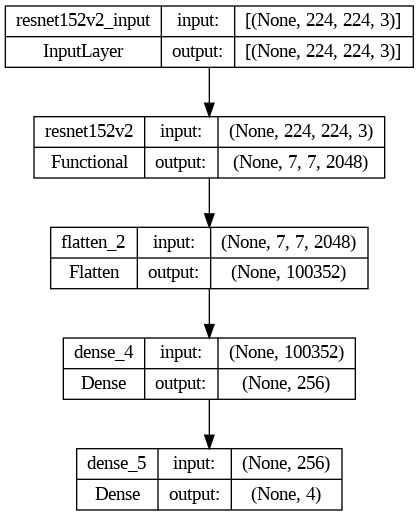

In [32]:
# 모델 구조 확인하기
# finetuned_model.summary()
tf.keras.utils.plot_model(no_augmented_model, show_shapes=True)

## (5) 학습 결과 시각화

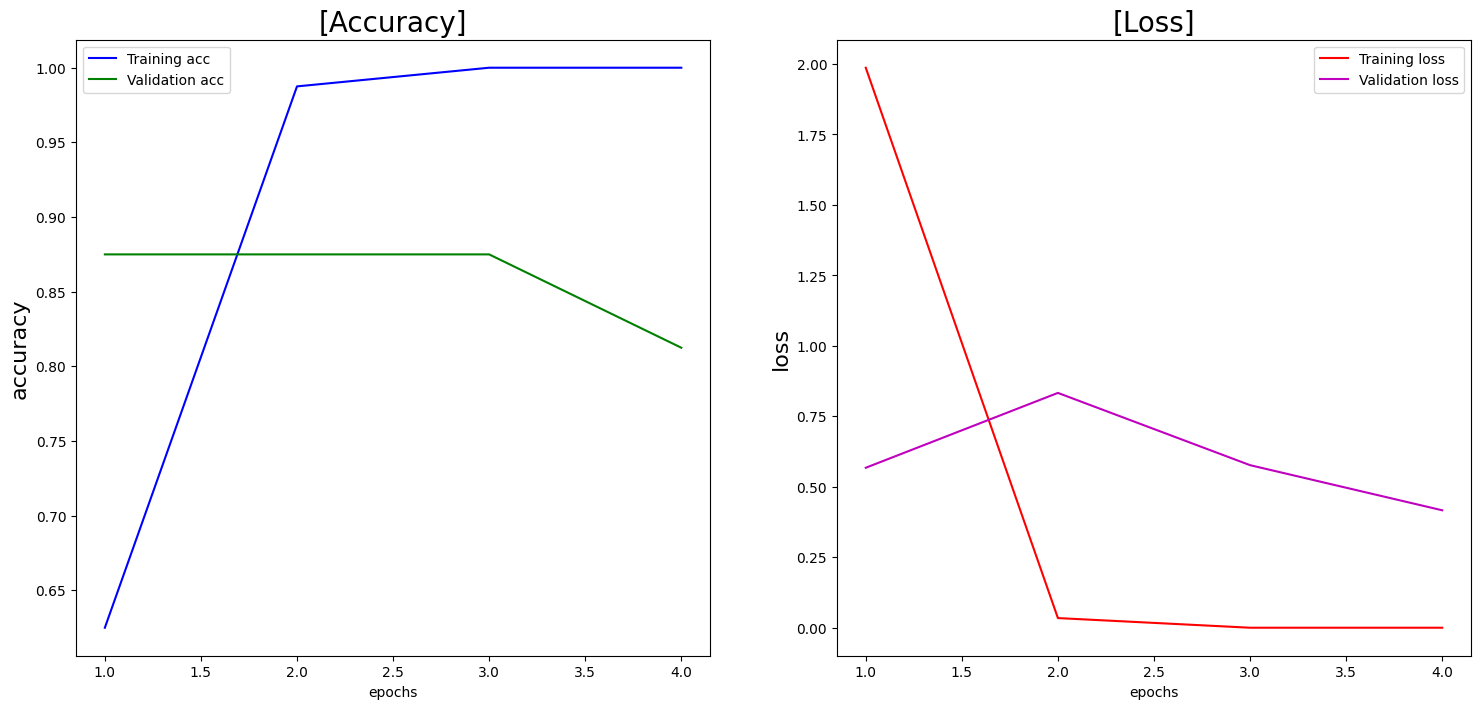

In [33]:
## 학습 결과 시각화

fig, ax = plt.subplots(1, 2, figsize=(18,8))

# accuracy, loss 추출 -> 그래프 y축 설정
train_acc = history_no_augmented.history['accuracy']
val_acc = history_no_augmented.history['val_accuracy']
train_loss = history_no_augmented.history['loss']
val_loss = history_no_augmented.history['val_loss']

# 그래프 x축
epochs = np.arange(1, len(train_acc)+1)

# accuracy 시각화
ax[0].plot(epochs, train_acc, c='b', label='Training acc')
ax[0].plot(epochs, val_acc, c='g', label='Validation acc')
ax[0].set_title('[Accuracy]', size=20)
ax[0].set_xlabel('epochs') # X축
ax[0].set_ylabel('accuracy', size=16) # y축
ax[0].legend() # 범례 생성

# loss 시각화
ax[1].plot(epochs, train_loss, c='r', label='Training loss')
ax[1].plot(epochs, val_loss, c='m', label='Validation loss')
ax[1].set_title('[Loss]', size=20)
ax[1].set_xlabel('epochs') # X축
ax[1].set_ylabel('loss', size=16) # y축
ax[1].legend() # 범례 생성

plt.show()

## (6) 평가용 데이터를 이용한 모델 성능 평가

In [34]:
### 평가용 폴더에 있는 이미지를 이용해서 분류 실행

# 필요한 함수 / 라이브러리 import
import os
from PIL import Image
from tensorflow.keras.applications.imagenet_utils import decode_predictions


# target_size 설정
HEIGHT = WIDTH = 224

# 평가용 폴더 이미지 경로 설정
image_path = []
filename_list = os.listdir(test_dir)
for name in filename_list :
    test_image_file = test_dir + '/' + name  # 폴더/이름.jpg
    image_path.append(test_image_file)
# print(f'평가용 이미지 경로 확인 : \n{image_path}')
# print('-'*80)

# 평가용 이미지를 이용한 평가 진행
for image in image_path :
    img = Image.open(image)

    # resize 실행
    img = img.resize((224,224))

    # 넘파이 배열로 변환
    img_array = np.array(img) # 연산을 위해 np로 변경

    # 이미지 픽셀에 대한 rescaling
    X = img_array/255 # 0~1 사이 값으로 변경

    # batch_size=1 적용 -> 이미지의 모양 -> (1, 224,224, 3)
    X = X.reshape((1,224,224,3))

    # 정답 label 설정
    label = category_list # ['keyboard', 'monitor', 'mouse', 'others']

    # 평가용 데이터를 이용한 예측
    pred = no_augmented_model.predict(X)

    # 예측 값중 확률이 가장 높은 인덱스 추출
    idx = np.argmax(pred[0])

    # 정답 -> 숫자 대신 폴더 이름(category)으로 출력
    name = label[idx]
    print(f'모델의 예측 label = \033[95m{name}\033[0m')

    # 예측 확률 추출
    print(f'accuracy = {np.max(pred)*100}')
    plt.axis('off')
    plt.imshow(img_array)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# [2] <font color='red'>데이터 증식</font>을 이용하여 이미지 분류하기

## (1) 데이터 증식 (augmentation) DataGenerator -> 입력 이미지 생성

In [35]:
### 학습용 데이터 증식 (O) / 검증용 입력 데이터 생성

# DataGenerator 객체 생성
datagen = DataGenerator()

# 학습용, 검증용 ImageDataGenerator 생성
train_datagen2 = datagen.make_datagen(augmentation=True)
val_datagen2 = datagen.make_datagen(False)

# 학습용, 검증용 입력 이미지 생성
train_generated2,val_generated2 = datagen.make_datagen_flow_from_dir(train_datagen2,val_datagen2)


Found 80 images belonging to 4 classes.
Found 16 images belonging to 4 classes.


## (2) Model 객체 생성 -> 모델 생성

In [36]:
# 학습 Model 객체 생성
augmented_model = Model('augmenteted_model')

# 모델 생성 메소드 호출 -> 모델 생성
augmented_model.make_pretrained_model()
augmented_model.make_finetuned_model()

## (3) 모델 학습 -> 학습결과 파일로 저장

In [37]:
# 모델 학습
augmented_save_filename = 'resnet_augmented_weight.hdf5'
history_augmented = augmented_model.training(augmented_save_filename,
                                             train_generated2,val_generated2)


Epoch 1/1000
4/4 [==============================] - ETA: 0s - loss: 3.7479 - accuracy: 0.4375
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/KDT/084.AdvancedProj/data/model/resnet_augmented_weight.hdf5
4/4 [==============================] - 20s 3s/step - loss: 3.7479 - accuracy: 0.4375 - val_loss: 0.3364 - val_accuracy: 0.8750
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.8375
Epoch 2: val_accuracy did not improve from 0.87500
4/4 [==============================] - 5s 1s/step - loss: 0.5863 - accuracy: 0.8375 - val_loss: 0.4803 - val_accuracy: 0.8750
Epoch 3/1000
4/4 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9500
Epoch 3: val_accuracy did not improve from 0.87500
4/4 [==============================] - 4s 937ms/step - loss: 0.1780 - accuracy: 0.9500 - val_loss: 1.0392 - val_accuracy: 0.8125
Epoch 4/1000
4/4 [==============================] - ETA: 0s - loss: 0.2378 - accu

In [38]:
augmented_save_filename = 'resnet_augmented_weight.hdf5'

## (4) [보충] 모델 불러오기

In [39]:
### [보충] 모델 불러오기

# 파일 경로 설정하기
file_path = checkpoint_dir + '/' + augmented_save_filename

# 모델 불러오기
augmented_model = tf.keras.models.load_model(file_path)

## (5) 학습 결과 시각화

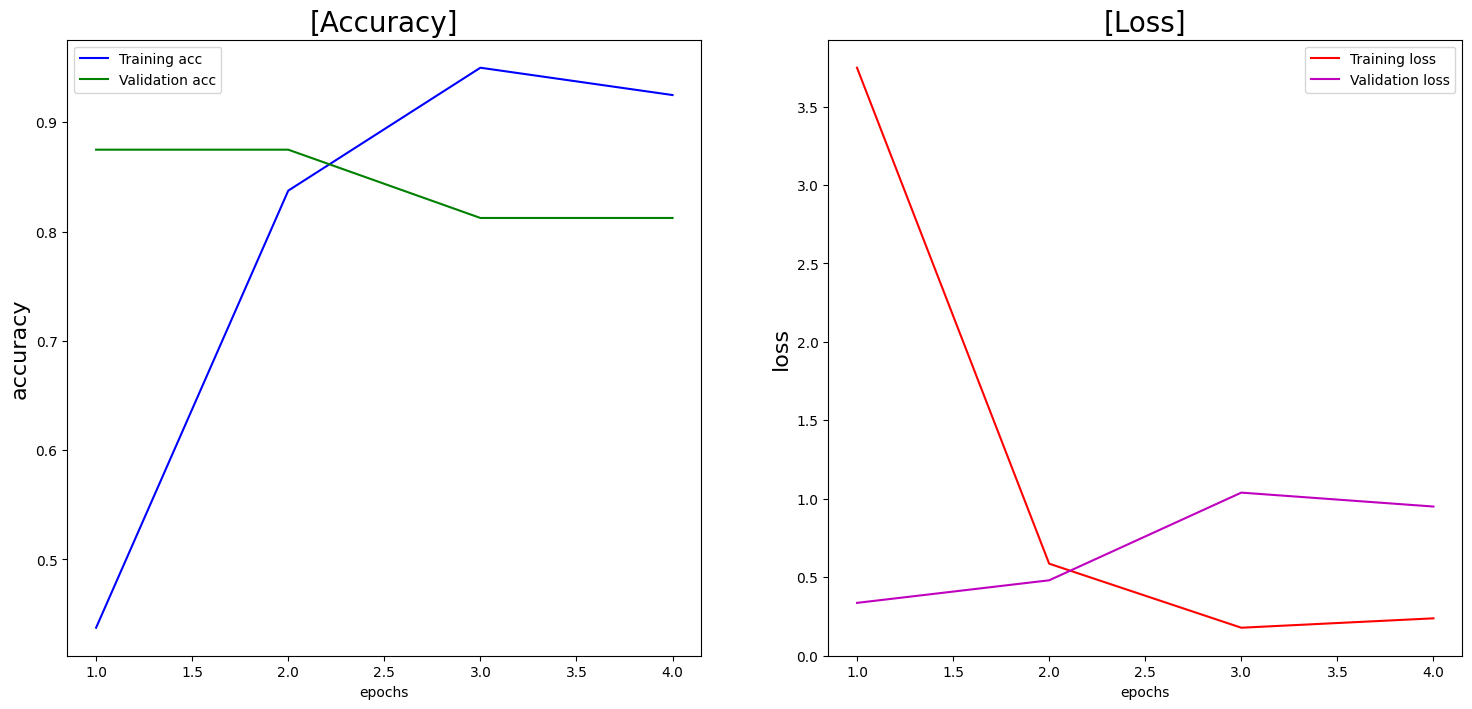

In [40]:
## 학습 결과 시각화

fig, ax = plt.subplots(1, 2, figsize=(18,8))

# accuracy, loss 추출 -> 그래프 y축 설정
train_acc = history_augmented.history['accuracy']
val_acc = history_augmented.history['val_accuracy']
train_loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']

# 그래프 x축
epochs = np.arange(1, len(train_acc)+1)

# accuracy 시각화
ax[0].plot(epochs, train_acc, c='b', label='Training acc')
ax[0].plot(epochs, val_acc, c='g', label='Validation acc')
ax[0].set_title('[Accuracy]', size=20)
ax[0].set_xlabel('epochs') # X축
ax[0].set_ylabel('accuracy', size=16) # y축
ax[0].legend() # 범례 생성

# loss 시각화
ax[1].plot(epochs, train_loss, c='r', label='Training loss')
ax[1].plot(epochs, val_loss, c='m', label='Validation loss')
ax[1].set_title('[Loss]', size=20)
ax[1].set_xlabel('epochs') # X축
ax[1].set_ylabel('loss', size=16) # y축
ax[1].legend() # 범례 생성

plt.show()

## (6) 평가용 데이터를 이용한 모델 성능 평가 (방법1)

In [41]:
### 평가용 폴더에 있는 이미지를 이용해서 분류 실행

# 필요한 함수 / 라이브러리 import
import os
from PIL import Image
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# target_size 설정
HEIGHT = WIDTH = 224

# 평가용 폴더 이미지 경로 설정
image_path = []
filename_list = os.listdir(test_dir)
for name in filename_list :
    test_image_file = test_dir + '/' + name  # 폴더/이름.jpg
    image_path.append(test_image_file)
# print(f'평가용 이미지 경로 확인 : \n{image_path}')
# print('-'*80)

# 평가용 이미지를 이용한 평가 진행
for image in image_path :
    img = Image.open(image)

    # resize 실행
    img = img.resize((224,224))

    # 넘파이 배열로 변환
    img_array = np.array(img) # 연산을 위해 np로 변경

    # 이미지 픽셀에 대한 rescaling
    X = img_array/255 # 0~1 사이 값으로 변경

    # batch_size=1 적용 -> 이미지의 모양 -> (1, 224,224, 3)
    X = X.reshape((1,224,224,3))

    # 정답 label 설정
    label = category_list # ['keyboard', 'monitor', 'mouse', 'others']

    # 평가용 데이터를 이용한 예측
    pred = augmented_model.predict(X)

    # ============= 방법 1
    # 예측 값중 확률이 가장 높은 인덱스 추출
    idx = np.argmax(pred[0])

    # 정답 -> 숫자 대신 폴더 이름(category)으로 출력
    name = label[idx]
    print(f'모델의 예측 label = \033[95m{name}\033[0m')

    # 예측 확률 추출
    print(f'accuracy = {np.max(pred)*100}')
    plt.axis('off')
    plt.imshow(img_array)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## 평가용 데이터를 이용한 모델 성능 평가 (방법2)

In [42]:
### 평가용 폴더에 있는 이미지를 이용해서 분류 실행

# 필요한 함수 / 라이브러리 import
import os
from PIL import Image
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# 평가용 폴더 이미지 경로 설정
image_path = []
filename_list = os.listdir(test_dir)
for name in filename_list :
    test_image_file = test_dir + '/' + name  # 폴더/이름.jpg
    image_path.append(test_image_file)
# print(f'평가용 이미지 경로 확인 : \n{image_path}')
# print('-'*80)

# 평가용 이미지를 이용한 평가 진행
for image in image_path :
    img = Image.open(image)

    # resize 실행
    img = img.resize((224,224))

    # 넘파이 배열로 변환
    img_array = np.array(img) # 연산을 위해 np로 변경

    # 이미지 픽셀에 대한 rescaling
    X = img_array/255 # 0~1 사이 값으로 변경

    # batch_size=1 적용 -> 이미지의 모양 -> (1, 224,224, 3)
    X = X.reshape((1,224,224,3))

    # 정답 label 설정
    label = category_list # ['keyboard', 'monitor', 'mouse', 'others']

    # 평가용 데이터를 이용한 예측
    pred = augmented_model.predict(X)

    # # ============= 방법 2
    # decoded_pred = decode_predictions(pred)
    # results = ''
    # for i, instance in enumerate(decoded_pred[0]) :
    #     results += '{}위: {} ({:.2f}%)'.format(i+1, instance[1], instance[2] * 100)


1/1 [==============================] - 0s 36ms/step
